<a href="https://colab.research.google.com/github/Mun-Robbery/kaggle_competitions/blob/main/Digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antrisole","key":"b94871d96930002e0e8ee14935e732a7"}'}

In [2]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [3]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 203MB/s]


In [4]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [9]:
train = pd.read_csv(r"../content/train.csv",dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# train test split
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)
# create feature and targets tensor for train set
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [12]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

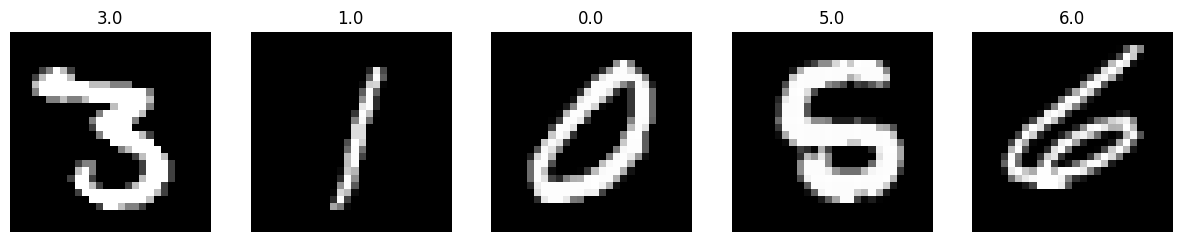

In [16]:
# visualize one of the images in data set
indices = [13,  15,  17,  19,  21]

# Создаем фигуру и оси с помощью subplot
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(15,  5))

# Проходим по выбранным индексам и отображаем изображения
for ax, index in zip(axes, indices):
    ax.imshow(features_numpy[index].reshape(28,  28), cmap='gray')
    ax.axis('off')
    ax.set_title(str(targets_numpy[index]))

# Сохраняем изображение
plt.savefig('multiple_graphs.png')

# Отображаем график
plt.show()

In [17]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [18]:
# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)

        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:
                test = Variable(images.view(-1, 28*28))

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8262349367141724  Accuracy: 66.73809814453125%
Iteration: 1000  Loss: 1.5984292030334473  Accuracy: 75.70237731933594%
Iteration: 1500  Loss: 1.2837188243865967  Accuracy: 78.78571319580078%
Iteration: 2000  Loss: 1.20073401927948  Accuracy: 80.28571319580078%
Iteration: 2500  Loss: 1.0419526100158691  Accuracy: 81.21428680419922%
Iteration: 3000  Loss: 0.9333316683769226  Accuracy: 82.04762268066406%
Iteration: 3500  Loss: 0.8946922421455383  Accuracy: 82.44047546386719%
Iteration: 4000  Loss: 0.7553079128265381  Accuracy: 83.07142639160156%
Iteration: 4500  Loss: 0.9651960134506226  Accuracy: 83.47618865966797%
Iteration: 5000  Loss: 0.8036523461341858  Accuracy: 83.72618865966797%
Iteration: 5500  Loss: 0.757362961769104  Accuracy: 84.05952453613281%
Iteration: 6000  Loss: 0.8686899542808533  Accuracy: 84.48809814453125%
Iteration: 6500  Loss: 0.6708242297172546  Accuracy: 84.67857360839844%
Iteration: 7000  Loss: 0.7171170115470886  Accuracy: 84.845237731933

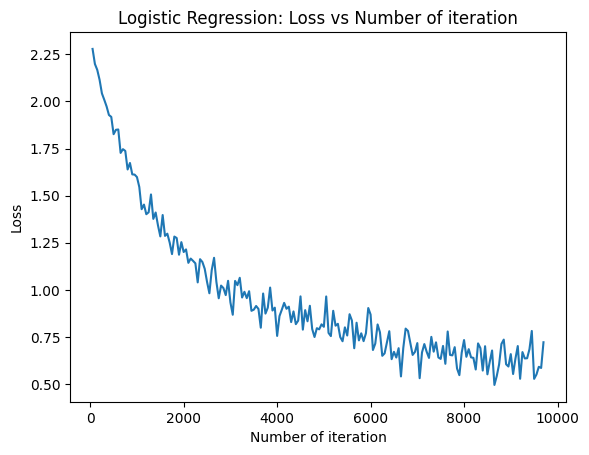

In [20]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()


**Artificial Neural Network (ANN)**

In [22]:
# Create ANN Model
class ANNModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()

        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()

        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)

        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

In [23]:
# instantiate ANN
input_dim = 28*28
hidden_dim = 150
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [24]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)

        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)

        # Calculating gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.7208170294761658  Accuracy: 79.0 %
Iteration: 1000  Loss: 0.45556309819221497  Accuracy: 87.94047546386719 %
Iteration: 1500  Loss: 0.21086890995502472  Accuracy: 89.6547622680664 %
Iteration: 2000  Loss: 0.2872692346572876  Accuracy: 90.73809814453125 %
Iteration: 2500  Loss: 0.30225157737731934  Accuracy: 92.19047546386719 %
Iteration: 3000  Loss: 0.12359312921762466  Accuracy: 92.77381134033203 %
Iteration: 3500  Loss: 0.23490220308303833  Accuracy: 93.55952453613281 %
Iteration: 4000  Loss: 0.0592273473739624  Accuracy: 94.10713958740234 %
Iteration: 4500  Loss: 0.2911022901535034  Accuracy: 94.44047546386719 %
Iteration: 5000  Loss: 0.09407395124435425  Accuracy: 94.73809814453125 %
Iteration: 5500  Loss: 0.19690370559692383  Accuracy: 94.8452377319336 %
Iteration: 6000  Loss: 0.17140638828277588  Accuracy: 95.0952377319336 %
Iteration: 6500  Loss: 0.09004642814397812  Accuracy: 95.58333587646484 %
Iteration: 7000  Loss: 0.10713982582092285  Accuracy: 95.78

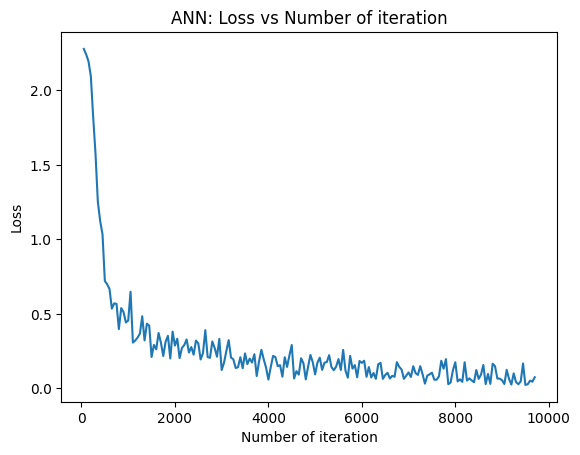

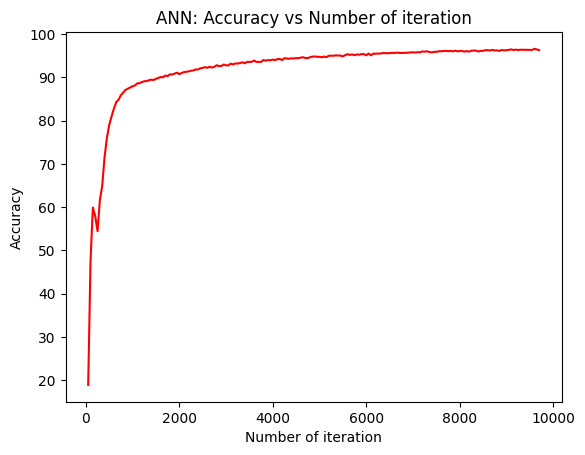

In [25]:
# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

**Convolutional Neural Network**

In [26]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2
        out = self.maxpool2(out)

        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

In [27]:
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

# Create CNN
model = CNNModel()

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)

        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)

        # Calculating gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                test = Variable(images.view(100,1,28,28))

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.11955124139785767  Accuracy: 96.48809814453125 %
Iteration: 1000  Loss: 0.06031695008277893  Accuracy: 97.39286041259766 %
Iteration: 1500  Loss: 0.039053093641996384  Accuracy: 97.60713958740234 %
Iteration: 2000  Loss: 0.01636453904211521  Accuracy: 98.11904907226562 %


In [67]:
test = pd.read_csv(r"../content/test.csv",dtype = np.float32)
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
pred_labels = []
img_id = range(1, 28001)

In [68]:
test_numpy = test.values/255
featuresTest = torch.from_numpy(test_numpy)

In [77]:
featuresTest.shape

torch.Size([28000, 784])

In [78]:
with torch.no_grad():
    test = Variable(featuresTest.view(28000,1,28,28))
    outputs = model(test)
    predicted = torch.max(outputs.data, 1)[1]

In [81]:
predicted = predicted.numpy()

In [87]:
len(img_id)

28000

In [88]:
submit = pd.DataFrame({'ImageId': list(img_id),
                       'Label': predicted})
submit.to_csv('submission.csv', index=False)